# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** to train the model to get really accurate results.

<img src="https://miro.medium.com/max/2800/1*TUF_YfybJPQ8WA0siWeJTg@2x.jpeg" alt="Brain" style="width: 800px;">

### Note

If you find this notebook helpful and intuitive, feel free to upvote it! Do give me your suggestions or opinions so that I can improve my work! I will highly appreciate it! Thank you! :)

---

# Importing Libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cvproject23/Radiology/Training/lung/Non-Covid (1153).png
/kaggle/input/cvproject23/Radiology/Training/lung/Covid (817).png
/kaggle/input/cvproject23/Radiology/Training/lung/Covid (631).png
/kaggle/input/cvproject23/Radiology/Training/lung/Covid (777).png
/kaggle/input/cvproject23/Radiology/Training/lung/Non-Covid (1031).png
/kaggle/input/cvproject23/Radiology/Training/lung/cp001_129.png
/kaggle/input/cvproject23/Radiology/Training/lung/6_Rahimzadeh_137covid_patient70_SR_4_IM00095.png
/kaggle/input/cvproject23/Radiology/Training/lung/Covid (297).png
/kaggle/input/cvproject23/Radiology/Training/lung/16_Morozov_study_0073_23.png
/kaggle/input/cvproject23/Radiology/Training/lung/Covid (556).png
/kaggle/input/cvproject23/Radiology/Training/lung/Non-Covid (1035).png
/kaggle/input/cvproject23/Radiology/Training/lung/Non-Covid (1223).png
/kaggle/input/cvproject23/Radiology/Training/lung/Covid (776).png
/kaggle/input/cvproject23/Radiology/Training/lung/16_Morozov_study_0251_19.png

---

# Color

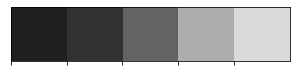

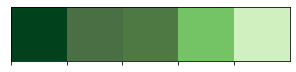

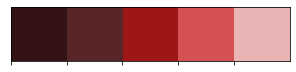

In [39]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [41]:
labels = ['brain','chest','lung']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [43]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/input/cvproject23/Radiology','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/cvproject23/Radiology','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 734/734 [00:06<00:00, 120.91it/s]


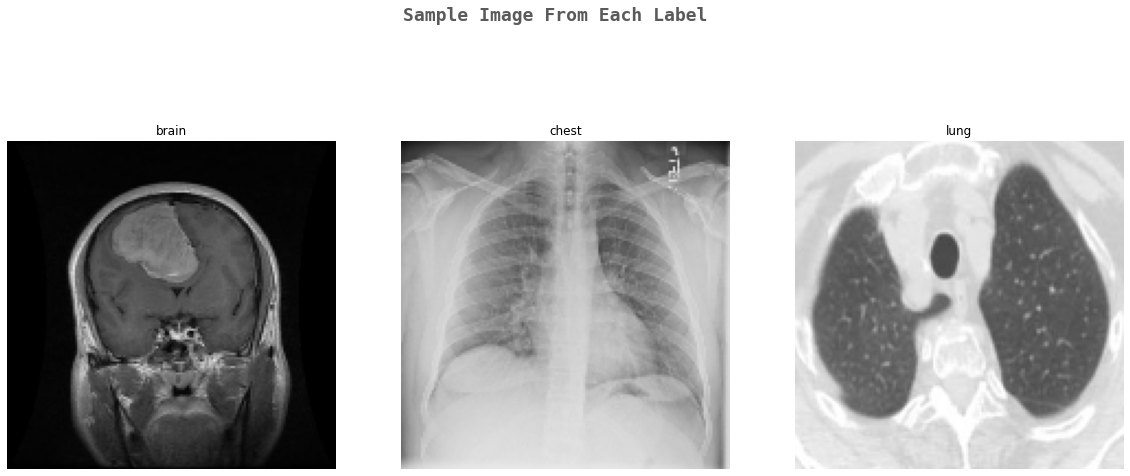

In [44]:
k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.7,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [45]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [46]:
X_train.shape

(8294, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [49]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (7464, 150, 150, 3)
7464 train samples
830 test samples
7464  ytest samples
y_train shape: (7464,)


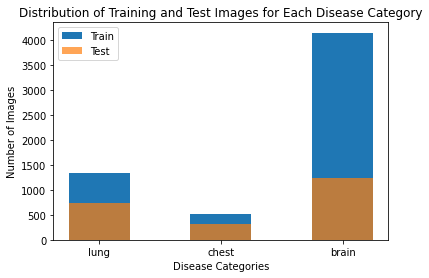

In [51]:
import os
import matplotlib.pyplot as plt

categories = ['lung', 'chest', 'brain']

def count_images(path):
    count_per_category = {category: 0 for category in categories}
    for category in categories:
        category_path = os.path.join(path, category)
        count_per_category[category] = len(os.listdir(category_path))
    return count_per_category

train_count = count_images('/kaggle/input/cvproject23/Radiology/Training')
test_count = count_images('/kaggle/input/cvproject23/Radiology/Testing')

bar_width = 0.5
index = range(len(categories))

plt.bar(index, train_count.values(), bar_width, label='Train')
plt.bar(index, test_count.values(), bar_width, label='Test', alpha=0.7)

plt.xlabel('Disease Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Training and Test Images for Each Disease Category')
plt.xticks(index, categories)
plt.legend()
plt.show()

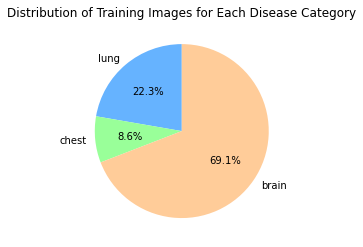

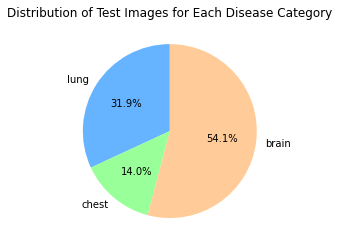

In [52]:
fig, ax = plt.subplots()
ax.pie(train_count.values(), labels=categories, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ffcc99'])
ax.set_title('Distribution of Training Images for Each Disease Category')
plt.show()

fig, ax = plt.subplots()
ax.pie(test_count.values(), labels=categories, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ffcc99'])
ax.set_title('Distribution of Test Images for Each Disease Category')
plt.show()

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [53]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [106]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [107]:
from tensorflow.keras.layers import Dropout

model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = Dropout(rate=0.3)(model)  # Additional Dropout layer
model = tf.keras.layers.Dense(256, activation='relu')(model)
model = Dropout(rate=0.2)(model)  # Additional Dropout layer
model = tf.keras.layers.Dense(3, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [108]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 150, 150, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 150, 150, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_5[0][0]            
____________________________________________________________________________________________

We finally compile our model.

In [109]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [111]:
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("effnetproposedv2.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001,
                              mode='auto', verbose=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [112]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=12,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping],
    steps_per_epoch=len(X_train) // 512  # Adjust this value as needed
)


Epoch 1/12
14/14 [==============================] - 14s 389ms/step - loss: 0.4545 - accuracy: 0.7939 - val_loss: 0.0662 - val_accuracy: 0.9960

Epoch 00001: val_accuracy improved from -inf to 0.99598, saving model to effnetproposedv2.h5
Epoch 2/12
14/14 [==============================] - 2s 151ms/step - loss: 0.1075 - accuracy: 0.9858 - val_loss: 0.0401 - val_accuracy: 0.9960

Epoch 00002: val_accuracy did not improve from 0.99598
Epoch 3/12
14/14 [==============================] - 2s 153ms/step - loss: 0.0073 - accuracy: 0.9967 - val_loss: 0.1301 - val_accuracy: 0.9893

Epoch 00003: val_accuracy did not improve from 0.99598

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
14/14 [==============================] - 2s 150ms/step - loss: 0.0664 - accuracy: 0.9889 - val_loss: 0.1123 - val_accuracy: 0.9933

Epoch 00004: val_accuracy did not improve from 0.99598
Epoch 5/12
14/14 [==============================] - 2s 152ms/step - loss: 0.0484 - accur

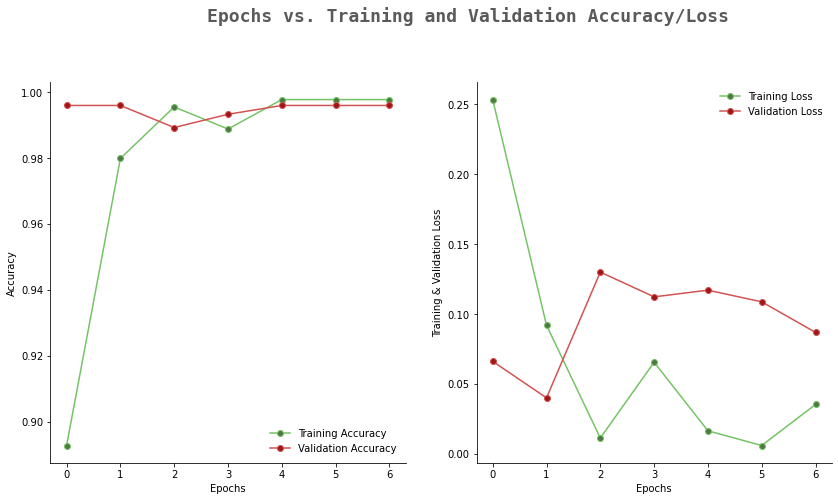

In [114]:
filterwarnings('ignore')

epochs = [i for i in range(len(train_acc))]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [115]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

In this, <br>
0 - Brain<br>
1 - Chest<br>
2 - Lung<br>

In [116]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       548
           1       1.00      0.93      0.96        86
           2       0.97      1.00      0.98       196

    accuracy                           0.99       830
   macro avg       0.99      0.98      0.98       830
weighted avg       0.99      0.99      0.99       830



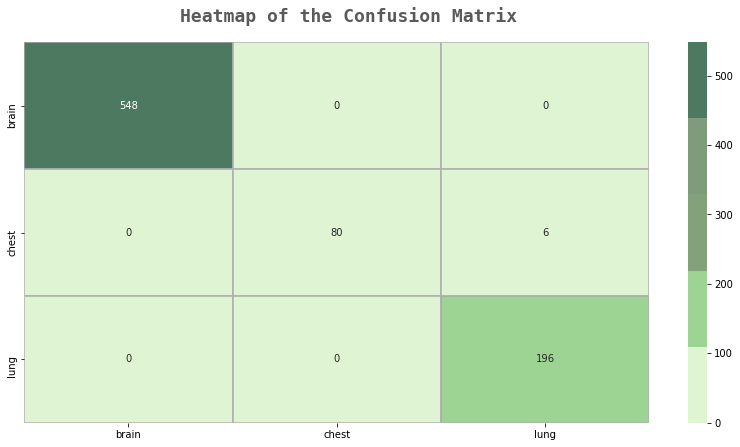

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3], fmt='g')
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()


---

# Bonus Content: Widgets

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.<br>
Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)

In [120]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='MRI Brain'
    elif p==1:
        p='XRAY Chest'
    else:
        p='CT-Scan Lung'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [121]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [122]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

---

# Conclusion

In this notebook, I performed Image Classification with the help of CNN using Transfer Learning which gave an accuracy of around 98%.<br>
I also made widgets which can make predictions on an image from your local machine!

---

# <center>Thank You!